> Ren C, Ji J H, Yan H Y, et al. A backstepping control method for mobile robot path tracking[C]//3rd Annual International Conference on Mechanics and Mechanical Engineering (MME 2016). Atlantis Press, 2016: 680-687.

定义世界坐标系下的：小车定位$\begin{bmatrix}{x},{y},{\theta}\end{bmatrix}$，小车线速度和角速度$\begin{bmatrix}v, w\end{bmatrix}$。参考点(reference point)：$\begin{bmatrix}{x_r},{y_r},{\theta_r}\end{bmatrix}$，参考速度：$\begin{bmatrix}v_r, w_r\end{bmatrix}$。

定义误差模型（参考点相对于定位点的误差）：
$$
\begin{bmatrix} {\dot x_e} \\ {\dot y_e} \\ {\dot \theta_e} \end{bmatrix} =
\begin{bmatrix} {w \cdot y_e -v + v_r \cdot cos\theta_e} \\
                {- w \cdot x_e + v_r \cdot sin\theta_e} \\
                {w_r - w} \end{bmatrix}
\tag{1}$$

论文根据Lyapunov第二法，基于backstepping得到的控制律

$$\begin{align}
v &= v_r cos\theta_e \nonumber \\
  &+ a_1 sin[arctan(w)wx_e - a_1 v_r sin(arctan(w)) sin\theta_e - a_1 cos(arctan(w))] \frac{1}{1+w^2}{\dot w}y_e \nonumber \\
  &+ a2[x_e - a_1 sin(arctan(w))y_e] \tag{2} \\
w &= w_r + 2 a_3 y_e v_r cos(\frac{\theta_e}{2}) + a_4 sin(\frac{\theta_e}{2}) \tag{3}
\end{align}$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [ ]:
def R_mat(x):
	return np.array([[np.cos(x), -np.sin(x)],
				     [np.sin(x),  np.cos(x)]])

def normalize_2pi(x):
	pi = np.pi
	x = x - np.floor(x / (2*pi)) * 2 * pi
	return x - 2*pi if x >= pi else x

class WheeledMobileRobot(object):
	def __init__(self, init_pos=[0., 0., 0.], ts=0.02) -> None:
		self._pos_now = init_pos
		self._ts = ts

	def update_odom(self, v, w):
		ts = self._ts
		delta_pos = [v * ts, 0., w * ts]
		pos_pre = self._pos_now
		theta_mean = normalize_2pi(pos_pre[2] + 0.5 * delta_pos[2])
		pos_new = pos_pre[0:2] + R_mat(theta_mean) @ np.array(delta_pos[0:2]).T
		self._pos_now[0:2] = pos_new.tolist()
		self._pos_now[2]   = normalize_2pi(pos_pre[2] + delta_pos[2])

	@property
	def pos_now(self):
		return self._pos_now

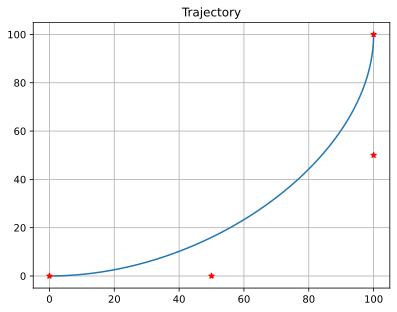

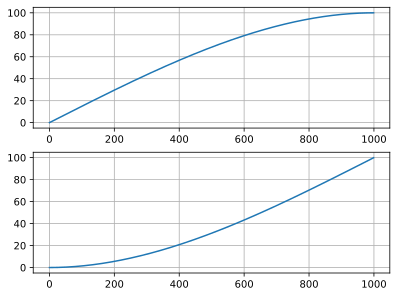

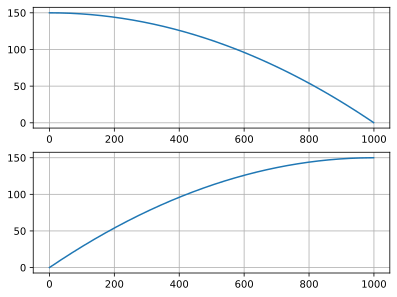

In [56]:
class BezierGenerator(object):
    def __init__(self):
        pass
    
    def getBezierTrajectory(self, start, end, control_points, delta_t=0.01):
        ts = np.arange(0., 1., delta_t)
        ctrl_pts = np.vstack([start, control_points, end])
        return self.getTMat(ts, len(control_points)+1) @ ctrl_pts
    
    def getBezierTrajectoryDerivative(self, start, end, control_points, delta_t=0.01):
        ts = np.arange(0., 1., delta_t)
        ctrl_pts = np.vstack([start, control_points, end])
        return self.getTDotMat(ts, len(control_points)+1) @ ctrl_pts
        
    def getTMat(self, t, degree):
        t_mat = []
        t_array = np.array(t)
        if degree == 1:
            t_mat = [1-t, t]
        elif degree == 2:
            t_mat = [(1-t)**2, 2*t*(1-t), t**2]
        elif degree == 3:
            t_mat = [(1-t)**3, 3*t*(1-t)**2, 3*(1-t)*t**2, t**3]
        else:
            t_mat = []
        
        return np.array(t_mat).T
    
    def getTDotMat(self, t, degree):
        t_mat = []
        t_array = np.array(t)
        if degree == 1:
            t_mat = [-1., 1.]
        elif degree == 2:
            t_mat = [2.*t-2., 2.-4.*t, 2.*t]
        elif degree == 3:
            t_mat = [-3.*(1.-t)**2, 3.*t*(2.*t-2.)+3.*(1.-t)**2, -3.*t**2+2.*t*(3.-3.*t), 3.*t**2]
        else:
            t_mat = []
        
        return np.array(t_mat).T

delta_t = 0.001
ts = np.arange(0., 1., delta_t)
start, end = [0., 0.], [100., 100.]
control_points = [[50., 0.], [100., 50.]]
ctrl_pts = np.vstack([start, control_points, end])

bezier = BezierGenerator()
bezier_traj = bezier.getBezierTrajectory(start, end, control_points, delta_t)
bezier_traj_dot = bezier.getBezierTrajectoryDerivative(start, end, control_points, delta_t)

if True:
    
    fig, ax = plt.subplots()
    ax.set_title('Trajectory')
    ax.grid()
    ax.plot(bezier_traj[:,0], bezier_traj[:,1])
    ax.plot(ctrl_pts[:,0], ctrl_pts[:,1], 'r*')
    
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(bezier_traj[:, 0]); ax[0].grid()
    ax[1].plot(bezier_traj[:, 1]); ax[1].grid()
    
    fig, ax = plt.subplots(2, 1)
    ax[0].grid()
    ax[0].plot(bezier_traj_dot[:, 0])
    ax[1].grid() 
    ax[1].plot(bezier_traj_dot[:, 1])

In [ ]:
bezier_traj_ds

In [ ]:
ts = 0.02
robot = WheeledMobileRobot(init_pos=[0., 0., 0.], ts=ts)

# simulation
t, t_end = 0., 10.
pos_traj = []
while t < t_end:
	v, w = 1., 1.
	robot.update_odom(v, w)
	pos_traj.append(robot.pos_now.copy())
	t += ts

pos_traj = np.array(pos_traj)

if True:
	fig, ax = plt.subplots()
	ax.grid()
	ax.plot(pos_traj[:,0], pos_traj[:,1])